In [149]:
%matplotlib inline

from HeaderP import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   }
plt.rcParams.update(params)

def fitpoints(x,y):
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    return p


from tqdm import trange
import math
def movingMed_time(x,y,x_window,delta_x_window):
    # medians output
    x_med=np.zeros(len(x))
    y_med=np.zeros(len(y))

    # define the boundaries of the windows
    if len(x)==0:
        return x_med,y_med
    window_min=float(min(x))
    window_max=float(window_min+delta_x_window)
    
    # max time
    maxtime=max(x)
    
    # break when time window hits the end
    while window_max<=maxtime+x_window:
        seldf=(x>=window_min) & (x<=window_max) # get points between the window
        
        x_med[seldf]=np.median(x[seldf]) # all values for these indices are subsituded with median time
        y_med[seldf]=np.median(y[seldf]) # all values for these indices are subsituded with median flux
        
        # slide the window
        window_min=window_min+delta_x_window
        window_max=window_max+delta_x_window
    return x_med, y_med

def calcmidval(x_med,y_med,x_val):
    sort_x_med,sort_y_med=zip(*sorted(zip(x_med,y_med)))
    sort_x_med=np.asarray(sort_x_med)
    sort_y_med=np.asarray(sort_y_med)
    if x_val in sort_x_med:
        m=(sort_x_med==x_val)
        #print(sort_y_med[m])
        return sort_y_med[m][0]
    else:
        for i in range(len(sort_x_med)):
            if sort_x_med[i]>x_val:
                if i==0:
                    return sort_y_med[0]
                else:
                    p=fitpoints([sort_x_med[i-1],sort_x_med[i]],[sort_y_med[i-1],sort_y_med[i]])
                    return p(x_val)
            return(sort_y_med[-1])
        
def calc_measure_disp(df,name,method='movingmedian',p=0):
    trytime=100
    agedisp=[]
    
    x,xerr=df['Age'].values,df['Age_err'].values
    y,yerr=df[name].values,df[name+'_ERR'].values
    
    if method=='movingmedian':
        for i in trange(trytime):
            df['newage']=np.array([np.random.normal(x[k], xerr[k],1)[0] for k in range(len(x))])
            #df['newabun']=np.array([np.random.normal(y[k], yerr[k],1)[0] for k in range(len(y))])
            df['newmed']=np.array([calcmidval(df['med_age'],df['med_abun'],i) for i in df['newage']])
        
            agedisp.append(np.std(y-df['newmed']))
            
    elif method=='linear':
        for i in trange(trytime):
            df['newage']=np.array([np.random.normal(x[k], xerr[k],1)[0] for k in range(len(x))])
            #df['newabun']=np.array([np.random.normal(y[k], yerr[k],1)[0] for k in range(len(y))])
            df['newmed']=p(df['newage'])
            
            agedisp.append(np.std(y-df['newmed']))
    orgdisp=np.std(y-p(x))
            
    return np.mean(np.array(agedisp)-orgdisp)**2.+np.median(yerr)**2


def calc_disp(df,name,method='movingmedian',p=0):
    df_dropna=df.dropna(subset=['med_age',name,'med_abun',name+'_ERR'])

    if method=='movingmedian':
        # calcualte total dispersion
        totdisp=np.mean((df_dropna[name]-df_dropna['med_abun'])**2.)
        #print(totdisp)
    
        # calculate measurement dispersion
        meadisp=calc_measure_disp(df,name)
        
    elif method=='linear':
        # calcualte total dispersion
        totdisp=np.std(df_dropna[name]-p(df_dropna['Age']))
        meadisp=calc_measure_disp(df,name,'linear',p)
        
    meadisp=meadisp
    #print(df['Age_err'])
    # calculate int dispersion
    intdisp=np.sqrt(totdisp**2-meadisp)
    print('total',totdisp,'measured',np.sqrt(meadisp),'intr',intdisp)
    return totdisp,intdisp


from scipy.ndimage import gaussian_filter

def tempcheck(df_abun_st_ha,df_abun_st_la,checkname='TEFF'):
    minval=min(min(df_abun_st_ha[checkname]),min(df_abun_st_la[checkname]))
    maxval=max(max(df_abun_st_ha[checkname]),max(df_abun_st_la[checkname]))
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}

    plt.figure(figsize=(22.5,25))
    cm = plt.cm.get_cmap('viridis',5)
    for i in range(1,len(abun_apog)):
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.reset_index(drop=True)
    
        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.reset_index(drop=True)
    
    
        plt.subplot(5,4,i+1)
        plt.scatter(df_plot_la['Age'],df_plot_la[abun_apog[i]],c=df_plot_la[checkname],vmin=minval,vmax=maxval)
        #plt.scatter(df_plot_ha['Age'],df_plot_ha[abun_apog[i]],s=1,c=df_plot_ha[checkname],vmin=minval,vmax=maxval)
        plt.ylabel(abund[abun_apog[i]]+'Fe]')
        plt.xlabel('Age [Gyr]')
    
    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,1)
    plt.scatter(df_plot_la['Age'],df_plot_la['M_H'],c=df_plot_la[checkname],vmin=minval,vmax=maxval,
            alpha=0.5,label='low-$\\alpha$')
    """
    plt.scatter(df_plot_ha['Age'],df_plot_ha['M_H'],c=df_plot_ha[checkname],vmin=minval,vmax=maxval,
            s=1,alpha=0.5,label='high-$\\alpha$')
    """
    
    plt.ylabel('Fe')
    plt.xlabel('Age [Gyr]')
    plt.legend()
 
    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,20)
    plt.scatter(df_plot_la['Age'],df_plot_la['C_FE']-df_plot_la['N_FE'],
             c=df_plot_la[checkname],alpha=0.5,vmin=minval,vmax=maxval,label='low-$\\alpha$')
    """
    plt.scatter(df_plot_ha['Age'],df_plot_ha['C_FE']-df_plot_ha['N_FE'],s=1,
             c=df_plot_ha[checkname],alpha=0.5,vmin=minval,vmax=maxval,label='high-$\\alpha$')
    """
    plt.ylabel('[C/N]')
    plt.xlabel('Age [Gyr]')
    plt.legend()


    plt.tight_layout()


    
def plotraw(df_abun_st_ha,df_abun_st_la):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[S/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}
    
    lim=[-0.5,0.5]
    limx=[0,15]
    plt.figure(figsize=(22.5,25))
    for i in range(1,len(abun_apog)):
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.reset_index(drop=True)
    
        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.reset_index(drop=True)
    
        plt.subplot(5,4,i+1)
        plt.errorbar(df_plot_la['Age'],df_plot_la[abun_apog[i]],yerr=df_plot_la[abun_apog[i]+'_ERR'],fmt='bo',alpha=0.5,label='low-$\\alpha$')
        plt.errorbar(df_plot_ha['Age'],df_plot_ha[abun_apog[i]],yerr=df_plot_ha[abun_apog[i]+'_ERR'],fmt='ro',alpha=0.5,label='high-$\\alpha$')
    
    
        plt.ylabel(abund[abun_apog[i]]+'Fe]')
        plt.xlabel('Age [Gyr]')
        plt.ylim(lim)
        plt.xlim(limx)
        plt.legend()
    
    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,1)
    plt.errorbar(df_plot_la['Age'],df_plot_la['M_H'],fmt='bo',alpha=0.5,label='low-$\\alpha$')
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['M_H'],fmt='ro',alpha=0.5,label='high-$\\alpha$')
    
    plt.ylabel('Fe')
    plt.xlabel('Age [Gyr]')
    plt.legend()
    plt.ylim(lim)
    plt.xlim(limx)
 
    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,20)
    plt.errorbar(df_plot_la['Age'],df_plot_la['C_FE']-df_plot_la['N_FE'],
             fmt='bo',alpha=0.5,label='low-$\\alpha$')
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['C_FE']-df_plot_ha['N_FE'],
             fmt='ro',alpha=0.5,label='high-$\\alpha$')
    
    plt.ylabel('[C/N]')
    plt.xlabel('Age [Gyr]')
    plt.legend()
    plt.ylim(lim)
    plt.xlim(limx)


    plt.tight_layout()
    

def plotagedis(df_abun_st_ha,df_abun_st_la,agebin,start,end):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}
    
    size=int(np.ceil((end-start)/agebin))
    age_binned=[(2*j+1)*agebin/2+start for j in range(size)]

    ## running median parameters
    agewindow=0.5
    slidwindow=0.1

    # **************************************** #
    plt.figure(figsize=(22.5,25))
    for i in range(1,len(abun_apog)):
        clear_output(wait = True)
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age']<10]
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<3]
        df_plot_ha=df_plot_ha.reset_index(drop=True)

        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.loc[df_plot_la['Age']<10]
        df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<3]
        df_plot_la=df_plot_la.reset_index(drop=True)


        df_plot_la=df_plot_la.sort_values(by=['Age'])
        df_plot_ha=df_plot_ha.sort_values(by=['Age'])



        df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                    df_plot_la[abun_apog[i]].values,
                                                                    agewindow,slidwindow)
        df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                    df_plot_ha[abun_apog[i]].values,
                                                                    agewindow,slidwindow)

        df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
        df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)

        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)


        plt.subplot(5,4,i+1)


        if len(df_plot_la['Age'])!=0:   
            print(abun_apog[i])

            dispersions_la=[]
            dispersions_ha=[]
            dispersions_la_err=[]
            dispersions_ha_err=[]
            for j in range(size):
                agemin=j*agebin+start
                agemax=(j+1)*agebin+start

                new_df_inbin_la=df_plot_la.loc[df_plot_la['R']>agemin]
                new_df_inbin_la=new_df_inbin_la.loc[new_df_inbin_la['Age']<agemax]
                
                new_df_inbin_ha=df_plot_ha.loc[df_plot_ha['R']>agemin]
                new_df_inbin_ha=new_df_inbin_ha.loc[new_df_inbin_ha['Age']<agemax]
                print(len(new_df_inbin_la),len(new_df_inbin_ha))

                tot_la,disp_la=calc_disp(new_df_inbin_la,abun_apog[i])
                tot_ha,disp_ha=calc_disp(new_df_inbin_ha,abun_apog[i])

                dispersions_la.append(disp_la)
                dispersions_ha.append(disp_ha)
                
                if len(new_df_inbin_la)==0:
                    range_la=0
                else:
                    range_la=max(new_df_inbin_la[abun_apog[i]])-min(new_df_inbin_la[abun_apog[i]])
                if len(new_df_inbin_ha)==0:
                    range_ha=0
                else:
                    range_ha=max(new_df_inbin_ha[abun_apog[i]])-min(new_df_inbin_ha[abun_apog[i]])
                
                dispersions_la_err.append(range_la/np.sqrt(len(new_df_inbin_la)))
                dispersions_ha_err.append(range_ha/np.sqrt(len(new_df_inbin_ha)))

            plt.errorbar(age_binned,dispersions_la,yerr=dispersions_la_err,
                         fmt='b-o',label='low-$\\alpha$')
            plt.errorbar(age_binned,dispersions_ha,yerr=dispersions_ha_err,
                         fmt='r-o',label='high-$\\alpha$')

        plt.ylabel(abund[abun_apog[i]]+'Fe] dispersion')
        plt.xlabel('Radius [kpc]')


    plt.tight_layout()

# For sesmic stars

## Get high/low-$\alpha$ disk

Ages from https://ui.adsabs.harvard.edu/abs/2019yCat..22390032P/abstract

In [150]:
hdulist = fits.open('asu.fit')


In [151]:
df1 = pd.DataFrame(hdulist[1].data, dtype="float64")
df2 = pd.DataFrame(hdulist[2].data, dtype="float64")

In [152]:
df=pd.merge(df1,df2,left_on='KIC',right_on='KIC',how='inner')

In [153]:
df_apo=pd.read_pickle('/Users/yl4331/Desktop/ASTR/Columbia/GalacticArch/APOGEE.pkl')
df_apo['2MASS']=[i[2:] for i in df_apo['APOGEE_ID']]
df=pd.merge(df,df_apo,left_on='_2MASS',right_on='2MASS',how='inner')

In [154]:
def convd2R(x):
    return x/180*np.pi

df['X'] = df.GAIA_R_EST * np.cos(convd2R(df.GLAT)) * np.cos(convd2R(df.GLON)) / 1000.
df['Y'] = -df.GAIA_R_EST * np.sin(convd2R(df.GLON)) * np.cos(convd2R(df.GLAT))/ 1000.
df['z'] = df.GAIA_R_EST * np.sin(convd2R(df.GLAT))/ 1000.
df['R'] = np.sqrt(np.power(df.X - 8.2,2.) + np.power(df.Y,2.))


In [155]:
df['Age']=np.power(10,df['LogAge'])/1e3
df['Age_err']=(np.power(10,df['LogAge']+df['E_LogAge'])/1e3-np.power(10,df['LogAge']+df['e_logage_lc'])/1e3)/2

In [156]:
#df.to_pickle('ASstars.pkl')

In [157]:
np.median(df['Age_err'].dropna())


0.8777411473258232

In [158]:
print(len(df))
df=df.loc[df['Age_err']/df['Age']<0.3]
df=df.loc[df['M_H_ERR']<0.03].reset_index(drop=True)
print(len(df))
df=df.loc[df['SNR']>150].reset_index(drop=True)
print(len(df))

6727
5505
3917


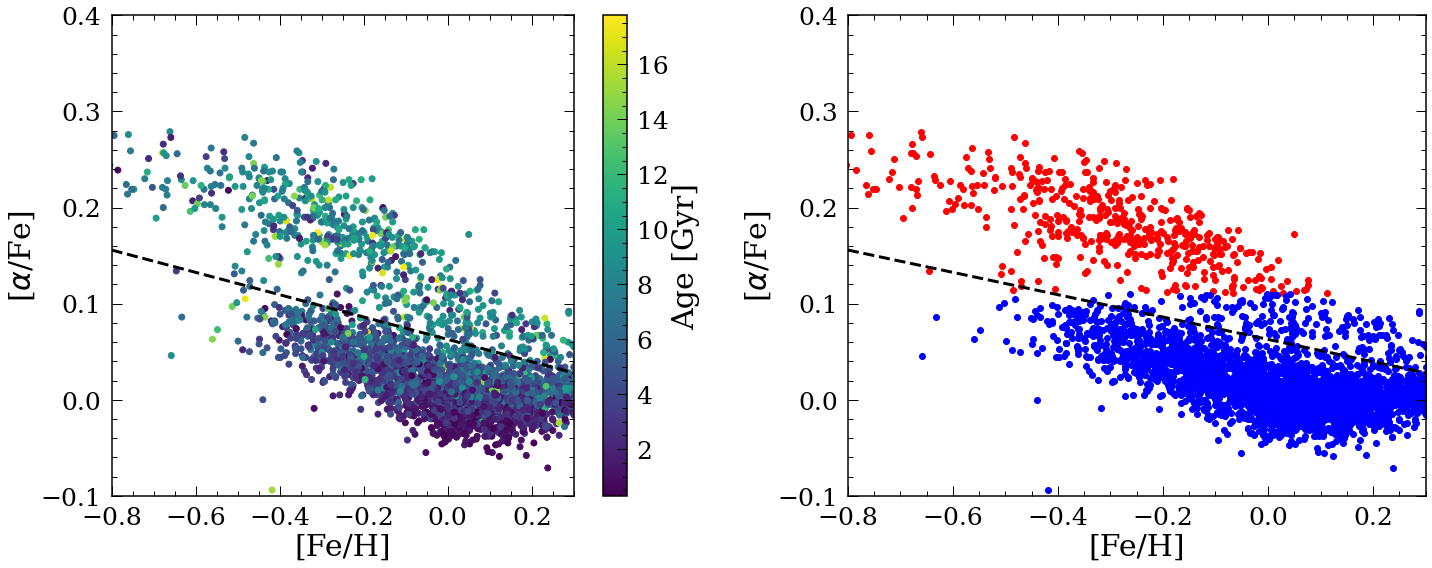

In [159]:
p=fitpoints([-0.75,0.11],[0.15,0.05])

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',5)
plt.scatter(df['FeH'],df['AFe'],c=df['Age'])
plt.plot([-0.8,0.3],p([-0.8,0.3]),'k--',linewidth=3)
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')
cb=plt.colorbar()
cb.set_label('Age [Gyr]')


#high_alpha=df[df['AFe']-p(df['FeH'])>=0]
#low_alpha=df[df['AFe']-p(df['FeH'])<0]

high_alpha=df[df['AFe']>=0.11]
low_alpha=df[df['AFe']<0.11]




p=fitpoints([-0.75,0.11],[0.15,0.05])

plt.subplot(1,2,2)
plt.scatter(high_alpha['FeH'],high_alpha['AFe'],c='r')
plt.scatter(low_alpha['FeH'],low_alpha['AFe'],c='b')
plt.plot([-0.8,0.3],p([-0.8,0.3]),'k--',linewidth=3)
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')

plt.tight_layout()

## Select temperature range and plot individual element abundance trend

In [160]:
Ferange=0.05

df_abun_st_ha=high_alpha.loc[abs(high_alpha['M_H']+0.2)<Ferange]
df_abun_st_la=low_alpha.loc[abs(low_alpha['M_H']+0.2)<Ferange]

df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['Age'])<10]
df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['Age'])<10]


print(len(df_abun_st_la),len(df_abun_st_ha))

420 60


In [93]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)
    
from scipy.ndimage import gaussian_filter
import emcee
def plotTrends(df_abun_st_ha,df_abun_st_la):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[C/','MG_FE':'[Mg/','AL_FE':'[Al/','SI_FE':'[Si/','S_FE':'[S/',
       'CA_FE':'[Ca/','TI_FE':'[Ti/','CR_FE':'[Cr/','MN_FE':'[Mn/','CO_FE':'[Co/',
       'NI_FE':'[Ni/','CU_FE':'[Cu/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
       'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}


    # **************************************** #

    Abunname=np.array(np.zeros((len(abun_apog))),dtype=str)
    hi_dis=np.zeros((len(abun_apog),3))
    lo_dis=np.zeros((len(abun_apog),3))
    
    hi_m=np.zeros((len(abun_apog),3))
    lo_m=np.zeros((len(abun_apog),3))
   
    hi_b=np.zeros((len(abun_apog),3))
    lo_b=np.zeros((len(abun_apog),3))
    
    nwalkers = 64
    
    
    for i in range(len(abun_apog)):
        #clear_output(wait = True)
        print(abun_apog[i])
        
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.dropna(subset=['Age','Age_err',abun_apog[i],abun_apog[i]+"_ERR"])
        df_plot_ha=df_plot_ha.reset_index(drop=True)
    
        
        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.dropna(subset=['Age','Age_err',abun_apog[i],abun_apog[i]+"_ERR"])
        df_plot_la=df_plot_la.reset_index(drop=True)
    
    
        df_plot_la=df_plot_la.sort_values(by=['Age'])
        df_plot_ha=df_plot_ha.sort_values(by=['Age'])
    
        if len(df_plot_la)==0 or len(df_plot_ha)==0:
            continue
        
        ha_age=df_plot_ha['Age'].values
        ha_age_err=df_plot_ha['Age_err'].values
        ha_ab=df_plot_ha[abun_apog[i]].values
        ha_ab_err=df_plot_ha[abun_apog[i]+'_ERR'].values
        
        la_age=df_plot_la['Age'].values
        la_age_err=df_plot_la['Age_err'].values
        la_ab=df_plot_la[abun_apog[i]].values
        la_ab_err=df_plot_la[abun_apog[i]+'_ERR'].values
        
        print('2',i)
        z_la = np.polyfit(la_age,la_ab,1)
        z_ha = np.polyfit(ha_age,ha_ab,1)
        
        print(len(ha_age),len(la_age))
        
        #####
        S_ha = np.zeros((len(df_plot_ha),2,2))
        S_la = np.zeros((len(df_plot_la),2,2))
        for j in range(len(df_plot_ha)):
            S_ha[j,0,0] = ha_age_err[j]**2
            S_ha[j,1,1] = ha_ab_err[j]**2
        
        for j in range(len(df_plot_la)):
            S_la[j,0,0] = la_age_err[j]**2
            S_la[j,1,1] = la_ab_err[j]**2
        
        
        ##### for ha disk
        sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S_ha, ha_ab, ha_age))
        p0 = np.array([z_ha[0], z_ha[1], np.log(0.03)])
        p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
        pos, _, _ = sampler_scatter.run_mcmc(p0, 1000)
        sampler_scatter.reset()
        sampler_scatter.run_mcmc(pos, 6000)
        samples_scatter = sampler_scatter.flatchain

        # m
        mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
        q = np.diff(mcmc)
        hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]
        
        # b
        mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
        q = np.diff(mcmc)
        hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]
        
        # dispersion
        mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
        q = np.diff(mcmc)
        hi_dis[i,0], hi_dis[i,1], hi_dis[i,2] = mcmc[1], q[0], q[1]

        
        ##### for la disk
        sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S_la, la_ab, la_age))
        p0 = np.array([z_la[0], z_la[1], np.log(0.03)])
        p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
        pos, _, _ = sampler_scatter.run_mcmc(p0, 1000)
        sampler_scatter.reset()
        sampler_scatter.run_mcmc(pos, 6000)
        samples_scatter = sampler_scatter.flatchain

        # m
        mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
        q = np.diff(mcmc)
        lo_m[i,0], lo_m[i,1], lo_m[i,2] = mcmc[1], q[0], q[1]
        
        # b
        mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
        q = np.diff(mcmc)
        lo_b[i,0], lo_b[i,1], lo_b[i,2] = mcmc[1], q[0], q[1]
        
        # dispersion
        mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
        q = np.diff(mcmc)
        lo_dis[i,0], lo_dis[i,1], lo_dis[i,2] = mcmc[1], q[0], q[1]
        
     
        Abunname[i]=(abund[abun_apog[i]]+'Fe]')


    return hi_dis, lo_dis, hi_m, lo_m, hi_b, lo_b, Abunname


()
10380 independent samples of m
10239 independent samples of b
9764 independent samples of lambda


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

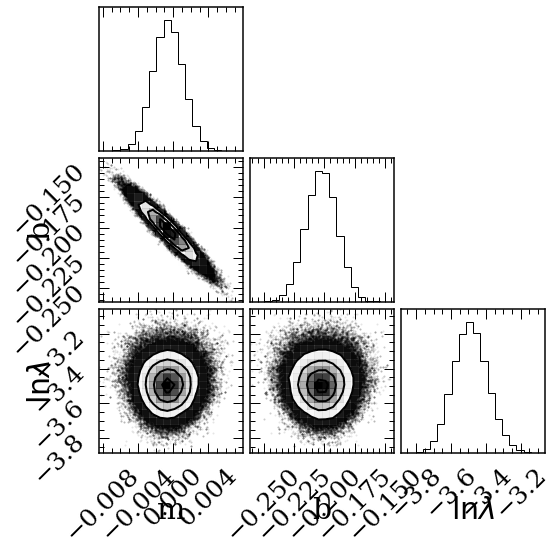

In [68]:
#### test for [C/Fe]
import corner
abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','S_FE']

abun_apog_err=[i+'_ERR' for i in abun_apog]

abund={'C_FE':'[C/','MG_FE':'[Mg/','AL_FE':'[Al/','SI_FE':'[Si/','S_FE':'[S/',
       'CA_FE':'[Ca/','TI_FE':'[Ti/','CR_FE':'[Cr/','MN_FE':'[Mn/','CO_FE':'[Co/',
       'NI_FE':'[Ni/','CU_FE':'[Cu/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
       'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}
    
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])
    
    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf
        
    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn
    
    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)
    
nwalkers = 64
    
    
i=0
        
df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
df_plot_ha=df_plot_ha.dropna(subset=['Age','Age_err',abun_apog[i],abun_apog[i]+"_ERR"])
df_plot_ha=df_plot_ha.reset_index(drop=True)
    
        
df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
df_plot_la=df_plot_la.dropna(subset=['Age','Age_err',abun_apog[i],abun_apog[i]+"_ERR"])
df_plot_la=df_plot_la.reset_index(drop=True)
    
    
df_plot_la=df_plot_la.sort_values(by=['Age'])
df_plot_ha=df_plot_ha.sort_values(by=['Age'])
        
ha_age=df_plot_ha['Age'].values
ha_age_err=df_plot_ha['Age_err'].values
ha_ab=df_plot_ha[abun_apog[i]].values
ha_ab_err=df_plot_ha[abun_apog[i]+'_ERR'].values
        
la_age=df_plot_la['Age'].values
la_age_err=df_plot_la['Age_err'].values
la_ab=df_plot_la[abun_apog[i]].values
la_ab_err=df_plot_la[abun_apog[i]+'_ERR'].values
        
z_la = np.polyfit(la_age,la_ab,1)
z_ha = np.polyfit(ha_age,ha_ab,1)
        
#####
S_ha = np.zeros((len(df_plot_ha),2,2))
S_la = np.zeros((len(df_plot_la),2,2))
for j in range(len(df_plot_ha)):
    S_ha[j,0,0] = ha_age_err[j]**2
    S_ha[j,1,1] = ha_ab_err[j]**2
        
for j in range(len(df_plot_la)):
    S_la[j,0,0] = la_age_err[j]**2
    S_la[j,1,1] = la_ab_err[j]**2
            
        
##### for ha disk
sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S_ha, ha_ab, ha_age))
p0 = np.array([z_ha[0], z_ha[1], np.log(0.03)])
p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
pos, _, _ = sampler_scatter.run_mcmc(p0, 1000)
sampler_scatter.reset()
sampler_scatter.run_mcmc(pos, 6000)
samples_scatter = sampler_scatter.flatchain
print(np.shape(sampler_scatter))
tau = sampler_scatter.get_autocorr_time(c=4)
nsamples = len(samples_scatter)
print("{0:.0f} independent samples of m".format(nsamples / tau[0]))
print("{0:.0f} independent samples of b".format(nsamples / tau[1]))
print("{0:.0f} independent samples of lambda".format(nsamples / tau[2]))

corner.corner(samples_scatter, labels=["m", "b", "$\ln\lambda$"]);

from IPython.display import display, Math

labels = ["m", "b", "ln(λ)"]
for i in range(3):
    mcmc = np.percentile(samples_scatter[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


10385 independent samples of m
10743 independent samples of b
9781 independent samples of lambda


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

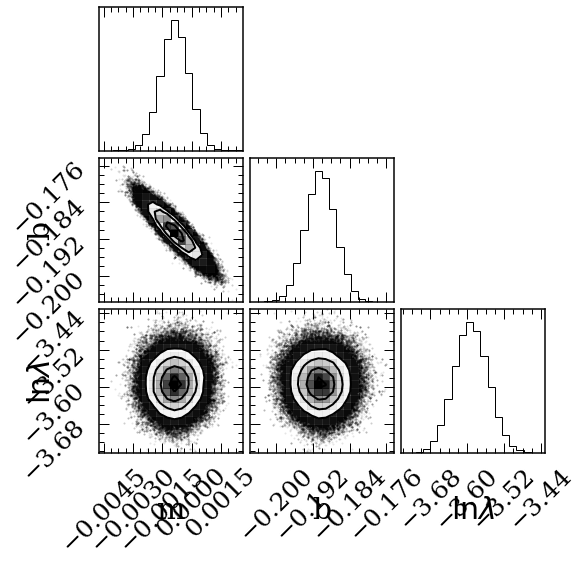

In [73]:
##### for la disk
sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S_la, la_ab, la_age))
p0 = np.array([z_la[0], z_la[1], np.log(0.03)])
p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
pos, _, _ = sampler_scatter.run_mcmc(p0, 1000)
sampler_scatter.reset()
sampler_scatter.run_mcmc(pos, 6000)
samples_scatter = sampler_scatter.flatchain

tau = sampler_scatter.get_autocorr_time(c=4)
nsamples = len(samples_scatter)
print("{0:.0f} independent samples of m".format(nsamples / tau[0]))
print("{0:.0f} independent samples of b".format(nsamples / tau[1]))
print("{0:.0f} independent samples of lambda".format(nsamples / tau[2]))

corner.corner(samples_scatter, labels=["m", "b", "$\ln\lambda$"]);

for i in range(3):
    mcmc = np.percentile(samples_scatter[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [94]:
abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE']

    
hi_dis, lo_dis, hi_m, lo_m, hi_b, lo_b, Abunname = plotTrends(df_abun_st_ha,df_abun_st_la)
    


M_H
2 0
60 420
0
C_FE
2 1
60 420
1
N_FE
2 2
60 420
2
O_FE
2 3
60 410
3
NA_FE
2 4
60 420
4
MG_FE
2 5
60 420
5
AL_FE
2 6
60 420
6
SI_FE
2 7
60 420
7
S_FE
2 8
60 420
8
K_FE
2 9
60 420
9
CA_FE
2 10
60 420
10
TI_FE
2 11
57 418
11
V_FE
2 12
59 220
12
MN_FE
2 13
59 419
13
NI_FE
2 14
60 420
14
P_FE
2 15
60 420
15
CR_FE
2 16
60 420
16
CO_FE
2 17
60 420
17


In [95]:
Abunname

array(['[Fe/Fe]', '[C/Fe]', '[N/Fe]', '[O/Fe]', '[Na/Fe]', '[Mg/Fe]',
       '[Al/Fe]', '[Si/Fe]', '[S/Fe]', '[K/Fe]', '[Ca/Fe]', '[Ti/Fe]',
       '[V/Fe]', '[Mn/Fe]', '[Ni/Fe]', '[P/Fe]', '[Cr/Fe]', '[Co/Fe]'],
      dtype='<U32')

In [105]:
df_disp=pd.DataFrame(np.array((Abunname,lo_dis[:,0], lo_dis[:,1],lo_dis[:,2], 
                               hi_dis[:,0], hi_dis[:,1],hi_dis[:,2],
                               hi_m[:,0], hi_m[:,1],hi_m[:,2], 
                               lo_m[:,0],lo_m[:,1],lo_m[:,2],
                               hi_b[:,0], hi_b[:,1], hi_b[:,2], 
                               lo_b[:,0],lo_b[:,1],lo_b[:,2])).T,
                     columns=['Abund','la_dis_astro','la_dis_astro_err1','la_dis_astro_err2',
                              'ha_dis_astro','ha_dis_astro_err1','ha_dis_astro_err2',
                              'ha_m_astro','ha_m_astro_err1','ha_m_astro_err2',
                              'la_m_astro','la_m_astro_err1','la_m_astro_err2',
                             'ha_b_astro','ha_b_astro_err1','ha_b_astro_err2',
                              'la_b_astro','la_b_astro_err1','la_b_astro_err2'])


In [106]:
#df_disp.to_pickle('astro_instrinsic.pkl')

# For red clump stars from the cannon

## Get high/low-$\alpha$ disk

In [107]:
abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','S_FE','C_N']
print(len(abun_apog))

20


In [108]:
df_CM=pd.read_pickle('CannonDR16_cut.pkl')
df_CM['C_N']=df_CM['C_FE']-df_CM['N_FE']
df_CM['C_N_ERR']=np.sqrt(df_CM['C_FE_ERR']**2.+df_CM['N_FE_ERR']**2.)

for i in abun_apog:
    df_CM=df_CM.loc[abs(df_CM[i])<5]
df_CM=df_CM.reset_index(drop=True)
print('before cutting:',len(df_CM))


# get red clump stars
df=df_CM.loc[df_CM['DP']>230]



before cutting: 64317


In [109]:
print('rc stars',len(df))

rc stars 22031


In [110]:
print(len(df))
df=df.loc[df['SNR']>150].reset_index(drop=True)
#df=df.loc[df['Age_err']/df['Age']<0.5].reset_index(drop=True)
df=df.loc[df['M_H_ERR']<0.03].reset_index(drop=True)
print(len(df))
df=df.loc[df['chisq']<10000].reset_index(drop=True)
print(len(df))

22031
13220
11263


64317 11263


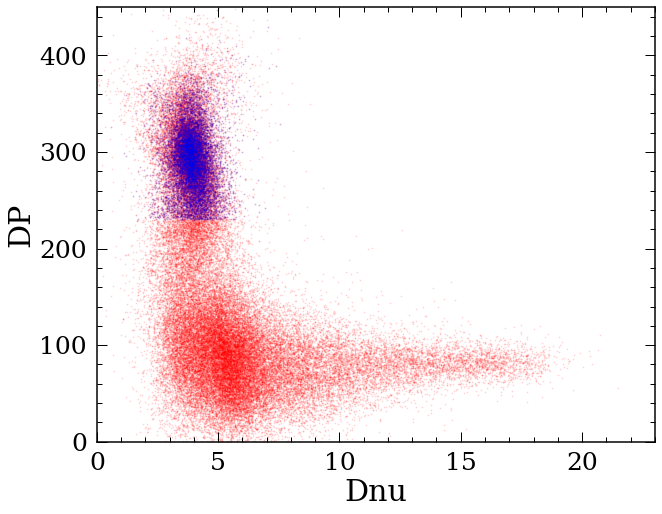

In [111]:
plt.figure(figsize=(10,8))
plt.scatter(df_CM['Dnu'],df_CM['DP'],c='r',alpha=0.1,s=1,label='All')
plt.scatter(df['Dnu'],df['DP'],c='b',alpha=0.1,s=1,label='Red Clumps')
plt.ylim([0,450])
plt.xlim([0,23])
plt.xlabel('Dnu')
plt.ylabel('DP')
print(len(df_CM),len(df))



8816 2447


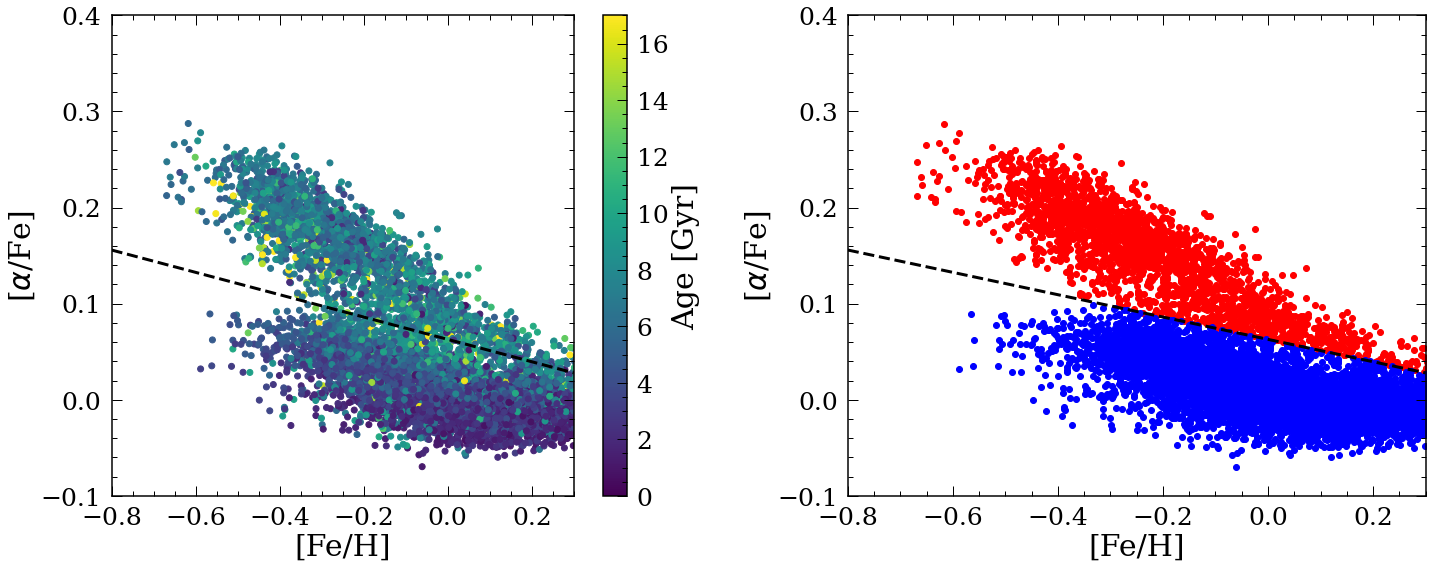

In [113]:
p=fitpoints([-0.75,0.11],[0.15,0.05])

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',5)
plt.scatter(df['M_H'],df['ALPHA_M'],c=df['Age'],vmin=0,vmax=17)
plt.plot([-0.8,0.3],p([-0.8,0.3]),'k--',linewidth=3)
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4]) 
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')
cb=plt.colorbar()
cb.set_label('Age [Gyr]')


high_alpha=df[df['ALPHA_M']-p(df['M_H'])>=0]
low_alpha=df[df['ALPHA_M']-p(df['M_H'])<0]

#high_alpha=df[df['ALPHA_M']>=0.11]
#low_alpha=df[df['ALPHA_M']<0.11]


print(len(low_alpha),len(high_alpha))

p=fitpoints([-0.75,0.11],[0.15,0.05])

plt.subplot(1,2,2)
plt.scatter(high_alpha['M_H'],high_alpha['ALPHA_M'],c='r')
plt.scatter(low_alpha['M_H'],low_alpha['ALPHA_M'],c='b')
plt.plot([-0.8,0.3],p([-0.8,0.3]),'k--',linewidth=3)
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')

plt.tight_layout()

## Select temperature range and plot individual element abundance trend

In [114]:
#rangeTeff=25
#tempcut=4674

df_abun_st_ha=high_alpha.loc[abs(high_alpha['M_H'])<0.05]
df_abun_st_la=low_alpha.loc[abs(low_alpha['M_H'])<0.05]

df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['Age'])<10]
df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['Age'])<10]


print(len(df_abun_st_ha),len(df_abun_st_la))



224 1650


In [119]:
abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE']

    
hi_dis, lo_dis, hi_m, lo_m, hi_b, lo_b, Abunname = plotTrends(df_abun_st_ha,df_abun_st_la)
    



M_H
2 0
224 1650
0
C_FE
2 1
224 1650
1
N_FE
2 2
224 1650
2
O_FE
2 3
224 1650
3
NA_FE
2 4
224 1650
4
MG_FE
2 5
224 1650
5
AL_FE
2 6
224 1650
6
SI_FE
2 7
224 1650
7
S_FE
2 8
224 1650
8
K_FE
2 9
224 1650
9
CA_FE
2 10
224 1650
10
TI_FE
2 11
224 1650
11
V_FE
2 12
224 1650
12
MN_FE
2 13
224 1650
13
NI_FE
2 14
224 1650
14
P_FE
2 15
224 1650
15
CR_FE
2 16
224 1650
16
CO_FE
2 17
224 1650
17


In [120]:
Abunname

array(['[Fe/Fe]', '[C/Fe]', '[N/Fe]', '[O/Fe]', '[Na/Fe]', '[Mg/Fe]',
       '[Al/Fe]', '[Si/Fe]', '[S/Fe]', '[K/Fe]', '[Ca/Fe]', '[Ti/Fe]',
       '[V/Fe]', '[Mn/Fe]', '[Ni/Fe]', '[P/Fe]', '[Cr/Fe]', '[Co/Fe]'],
      dtype='<U32')

In [121]:
df_disp_rc=pd.DataFrame(np.array((Abunname,lo_dis[:,0], lo_dis[:,1],lo_dis[:,2], 
                               hi_dis[:,0], hi_dis[:,1],hi_dis[:,2],
                               hi_m[:,0], hi_m[:,1],hi_m[:,2], 
                               lo_m[:,0],lo_m[:,1],lo_m[:,2],
                               hi_b[:,0], hi_b[:,1], hi_b[:,2], 
                               lo_b[:,0],lo_b[:,1],lo_b[:,2])).T,
                     columns=['Abund','la_dis_rc','la_dis_rc_err1','la_dis_rc_err2',
                              'ha_dis_rc','ha_dis_rc_err1','ha_dis_rc_err2',
                              'ha_m_rc','ha_m_rc_err1','ha_m_rc_err2',
                              'la_m_rc','la_m_rc_err1','la_m_rc_err2',
                             'ha_b_rc','ha_b_rc_err1','ha_b_rc_err2',
                              'la_b_rc','la_b_rc_err1','la_b_rc_err2'])



In [122]:
df_disp['Abund']=['Fe','C','N','O','Na','Mg','Al','Si','S','K','Ca','Ti','V','Mn','Ni','P','Cr','Co']
df_disp_rc['Abund']=['Fe','C','N','O','Na','Mg','Al','Si','S','K','Ca','Ti','V','Mn','Ni','P','Cr','Co']



In [123]:
df_disp_plot=pd.merge(df_disp,df_disp_rc,left_on='Abund',right_on='Abund',how='inner')
df_disp_plot

,Abund,la_dis_astro,la_dis_astro_err1,la_dis_astro_err2,ha_dis_astro,ha_dis_astro_err1,ha_dis_astro_err2,ha_m_astro,ha_m_astro_err1,ha_m_astro_err2,...,ha_m_rc_err2,la_m_rc,la_m_rc_err1,la_m_rc_err2,ha_b_rc,ha_b_rc_err1,ha_b_rc_err2,la_b_rc,la_b_rc_err1,la_b_rc_err2
0,Fe,-3.5919446262877357,0.03623413447544399,0.03688037921221632,-3.4886593913882846,0.09648475961923397,0.10074447434731493,-0.0005600956750691231,0.0016967196583412185,0.0017046362910117015,...,0.0009409897463959878,-0.0011573945256525791,0.000367556549603996,0.0003660150736007708,-0.0019795243747097483,0.006755796014398604,0.006538209480705317,0.005730862126227167,0.0015754881058293747,0.0015734592985891301
1,C,-3.042488849864662,0.0385617918670218,0.039051458038062314,-3.071062898492377,0.09724127012249006,0.10099278349740848,0.002389892874566823,0.0025650699610885765,0.0025770506069799793,...,0.0009857030781654438,0.009653966841986607,0.0005861626923729345,0.0005906902534043284,0.13264454684418636,0.007196795997549188,0.007150992076647794,-0.014857152395123677,0.002532002850926548,0.002579728368293963
2,N,-3.164453086172575,0.046867056728290724,0.046982220009830655,-2.678381633257331,0.10263920023962525,0.10631190228890963,-0.01543467858075433,0.0038489477646437356,0.003829611065584132,...,0.001323338661624358,-0.017824885491083395,0.0006675328469015404,0.0006605749307971552,0.21686677306021335,0.010540356711502774,0.010636563361437673,0.26474094160862466,0.002883321340588607,0.002874107753660593
3,O,-3.3499341538356537,0.0438386187489912,0.044178608339860315,-3.541631957802089,0.11266045290357152,0.11451667673819044,0.0010426013458601823,0.0017510767599557449,0.0017230314546567435,...,0.0007935517425596951,0.007839436925733696,0.0003538184880064934,0.00035422679503654964,0.11450105056770016,0.005554863511959107,0.00596202883956512,-0.027785641958209328,0.001414672887841053,0.0014186588930507997
4,Na,-2.3145140839980547,0.04235279221509769,0.04323466484998084,-1.9320754054983689,0.10257783429027123,0.10643987485638995,-0.01705058832636875,0.008074888971844413,0.008183259912838822,...,0.0032123373203287887,-0.03372328871586085,0.001447068897419461,0.0014551813189555562,0.09515733016156616,0.023404452489401123,0.021689635743027666,0.09482459570075558,0.0056611279623605265,0.005639973739823362
5,Mg,-3.582340314318108,0.04282967663202619,0.04283247544202062,-3.2932305623941964,0.09950324906284136,0.10328415376798628,0.001128380755379376,0.0021535968205628093,0.002094506177751202,...,0.001233124449931502,0.007355419077263453,0.00035421547164488955,0.0003580709489599543,0.15583218128159498,0.00868573009848575,0.00803553952136124,-0.016763598106849062,0.001457552710959948,0.0014329358643688419
6,Al,-3.35876254244441,0.04446371418427697,0.04513118132453542,-3.1155448633777967,0.1090711636769619,0.11238282770383323,-0.003765156426669909,0.0026465613301998488,0.002638973499690618,...,0.0014635915531487232,0.002122166419144626,0.0006432281980922137,0.0006573494405156879,0.12900720508196822,0.010121353234680122,0.009404006662874637,0.004675763931587595,0.002661844250702995,0.0026363382155149854
7,Si,-3.868980509951162,0.045649419805573466,0.04558922137818078,-3.6587027843151425,0.10587212138555557,0.110005149992912,-0.00014142700723385312,0.0015407218773713094,0.0015173079319029505,...,0.0009431989940708227,0.003465570010153926,0.00026270249395700775,0.000263505699452432,0.09713379903275197,0.0066190306894692436,0.006508838058759098,0.007236045802531268,0.0010547429218690377,0.0010398625217103155
8,S,-2.986461463343463,0.04968516011333479,0.04867388821228458,-2.9632384142605335,0.129647117466559,0.1301465969563207,-0.001434344926307957,0.0033760157730074415,0.0033459404037565546,...,0.0015329097558399135,0.004455693617627274,0.000513855966503076,0.0005151134087443433,0.12591916968490238,0.010887630317754221,0.010491675947431112,0.006563799736273475,0.002177788423520334,0.0021991976032120063
9,K,-2.612411110327055,0.04181871892912703,0.04237534962363565,-2.4100634635201867

In [135]:
colmnnum=[i for i in df_disp_plot.columns if i!='Abund']

In [137]:
for i in colmnnum:
    df_disp_plot[i]=pd.to_numeric(df_disp_plot[i])

In [138]:

errs1=np.exp((df_disp_plot['la_dis_rc']-df_disp_plot['la_dis_rc_err1']).values)
errs2=np.exp((df_disp_plot['la_dis_rc']+df_disp_plot['la_dis_rc_err2']).values)
df_disp_plot['la_dis_rc']=np.exp(df_disp_plot['la_dis_rc'].values)
df_disp_plot['la_dis_rc_err1']=abs(errs1-df_disp_plot['la_dis_rc'].values)
df_disp_plot['la_dis_rc_err2']=abs(errs2-df_disp_plot['la_dis_rc'].values)

errs1=np.exp((df_disp_plot['ha_dis_rc']-df_disp_plot['ha_dis_rc_err1']).values)
errs2=np.exp((df_disp_plot['ha_dis_rc']+df_disp_plot['ha_dis_rc_err2']).values)
df_disp_plot['ha_dis_rc']=np.exp(df_disp_plot['ha_dis_rc'].values)
df_disp_plot['ha_dis_rc_err1']=abs(errs1-df_disp_plot['ha_dis_rc'].values)
df_disp_plot['ha_dis_rc_err2']=abs(errs2-df_disp_plot['ha_dis_rc'].values)

errs1=np.exp((df_disp_plot['la_dis_astro']-df_disp_plot['la_dis_astro_err1']).values)
errs2=np.exp((df_disp_plot['la_dis_astro']+df_disp_plot['la_dis_astro_err2']).values)
df_disp_plot['la_dis_astro']=np.exp(df_disp_plot['la_dis_astro'].values)
df_disp_plot['la_dis_astro_err1']=abs(errs1-df_disp_plot['la_dis_astro'].values)
df_disp_plot['la_dis_astro_err2']=abs(errs2-df_disp_plot['la_dis_astro'].values)

errs1=np.exp((df_disp_plot['ha_dis_astro']-df_disp_plot['ha_dis_astro_err1']).values)
errs2=np.exp((df_disp_plot['ha_dis_astro']+df_disp_plot['ha_dis_astro_err2']).values)
df_disp_plot['ha_dis_astro']=np.exp(df_disp_plot['ha_dis_astro'].values)
df_disp_plot['ha_dis_astro_err1']=abs(errs1-df_disp_plot['ha_dis_astro'].values)
df_disp_plot['ha_dis_astro_err2']=abs(errs2-df_disp_plot['ha_dis_astro'].values)

In [139]:
df_disp_plot

,Abund,la_dis_astro,la_dis_astro_err1,la_dis_astro_err2,ha_dis_astro,ha_dis_astro_err1,ha_dis_astro_err2,ha_m_astro,ha_m_astro_err1,ha_m_astro_err2,...,ha_m_rc_err2,la_m_rc,la_m_rc_err1,la_m_rc_err2,ha_b_rc,ha_b_rc_err1,ha_b_rc_err2,la_b_rc,la_b_rc_err1,la_b_rc_err2
0,Fe,0.027545,0.000980,0.001035,0.030542,0.002809,0.003237,-0.000560,0.001697,0.001705,...,0.000941,-0.001157,0.000368,0.000366,-0.001980,0.006756,0.006538,0.005731,0.001575,0.001573
1,C,0.047716,0.001805,0.001900,0.046372,0.004297,0.004928,0.002390,0.002565,0.002577,...,0.000986,0.009654,0.000586,0.000591,0.132645,0.007197,0.007151,-0.014857,0.002532,0.002580
2,N,0.042237,0.001934,0.002032,0.068674,0.006699,0.007703,-0.015435,0.003849,0.003830,...,0.001323,-0.017825,0.000668,0.000661,0.216867,0.010540,0.010637,0.264741,0.002883,0.002874
3,O,0.035087,0.001505,0.001585,0.028966,0.003086,0.003514,0.001043,0.001751,0.001723,...,0.000794,0.007839,0.000354,0.000354,0.114501,0.005555,0.005962,-0.027786,0.001415,0.001419
4,Na,0.098814,0.004098,0.004366,0.144847,0.014121,0.016268,-0.017051,0.008075,0.008183,...,0.003212,-0.033723,0.001447,0.001455,0.095157,0.023404,0.021690,0.094825,0.005661,0.005640
5,Mg,0.027811,0.001166,0.001217,0.037134,0.003517,0.004040,0.001128,0.002154,0.002095,...,0.001233,0.007355,0.000354,0.000358,0.155832,0.008686,0.008036,-0.016764,0.001458,0.001433
6,Al,0.034778,0.001512,0.001606,0.044354,0.004583,0.005276,-0.003765,0.002647,0.002639,...,0.001464,0.002122,0.000643,0.000657,0.129007,0.010121,0.009404,0.004676,0.002662,0.002636
7,Si,0.020880,0.000932,0.000974,0.025766,0.002588,0.002996,-0.000141,0.001541,0.001517,...,0.000943,0.003466,0.000263,0.000264,0.097134,0.006619,0.006509,0.007236,0.001055,0.001040
8,S,0.050466,0.002446,0.002517,0.051651,0.006281,0.007179,-0.001434,0.003376,0.003346,...,0.001533,0.004456,0.000514,0.000515,0.125919,0.010888,0.010492,0.006564,0.002178,0.002199
9,K,0.073357,0.003004,0.003175,0.089810,0.008899,0.010110,-0.000110,0.005076,0.004964,...,0.002637,0.002959,0.000917,0.000908,0.162208,0.018598,0.016467,-0.005537,0.003847,0.003852


In [142]:
elements=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE']
 
ha_err=[]
la_err=[]
for i in elements:
    df_abun_st_ha=df_abun_st_ha.loc[df_abun_st_ha[i+"_ERR"]>0]
    df_abun_st_la=df_abun_st_la.loc[df_abun_st_la[i+"_ERR"]>0]
    ha_err.append(np.mean(df_abun_st_ha[i+"_ERR"].dropna()))
    la_err.append(np.mean(df_abun_st_la[i+"_ERR"].dropna()))
    
df_disp_plot['ha_rc_err_all']=ha_err
df_disp_plot['la_rc_err_all']=la_err

In [143]:

df_disp_plot['diff']=abs(df_disp_plot['la_m_rc']-df_disp_plot['ha_m_rc'])


In [144]:
df_disp_plot=df_disp_plot.sort_values(by='diff',ascending=False)

In [145]:
df_disp_plot

,Abund,la_dis_astro,la_dis_astro_err1,la_dis_astro_err2,ha_dis_astro,ha_dis_astro_err1,ha_dis_astro_err2,ha_m_astro,ha_m_astro_err1,ha_m_astro_err2,...,la_m_rc_err2,ha_b_rc,ha_b_rc_err1,ha_b_rc_err2,la_b_rc,la_b_rc_err1,la_b_rc_err2,ha_rc_err_all,la_rc_err_all,diff
4,Na,0.098814,0.004098,0.004366,0.144847,0.014121,0.016268,-0.017051,0.008075,0.008183,...,0.001455,0.095157,0.023404,0.021690,0.094825,0.005661,0.005640,0.035628,0.036986,0.014918
9,K,0.073357,0.003004,0.003175,0.089810,0.008899,0.010110,-0.000110,0.005076,0.004964,...,0.000908,0.162208,0.018598,0.016467,-0.005537,0.003847,0.003852,0.028150,0.028426,0.010250
6,Al,0.034778,0.001512,0.001606,0.044354,0.004583,0.005276,-0.003765,0.002647,0.002639,...,0.000657,0.129007,0.010121,0.009404,0.004676,0.002662,0.002636,0.017253,0.017622,0.009742
5,Mg,0.027811,0.001166,0.001217,0.037134,0.003517,0.004040,0.001128,0.002154,0.002095,...,0.000358,0.155832,0.008686,0.008036,-0.016764,0.001458,0.001433,0.009923,0.010072,0.009131
2,N,0.042237,0.001934,0.002032,0.068674,0.006699,0.007703,-0.015435,0.003849,0.003830,...,0.000661,0.216867,0.010540,0.010637,0.264741,0.002883,0.002874,0.014634,0.015825,0.009003
15,P,0.116151,0.005256,0.005445,0.087509,0.011439,0.012856,-0.000307,0.005882,0.005896,...,0.001399,0.096343,0.020262,0.019747,-0.033333,0.005917,0.005847,0.052761,0.056552,0.008096
1,C,0.047716,0.001805,0.001900,0.046372,0.004297,0.004928,0.002390,0.002565,0.002577,...,0.000591,0.132645,0.007197,0.007151,-0.014857,0.002532,0.002580,0.009118,0.010033,0.007516
3,O,0.035087,0.001505,0.001585,0.028966,0.003086,0.003514,0.001043,0.001751,0.001723,...,0.000354,0.114501,0.005555,0.005962,-0.027786,0.001415,0.001419,0.011333,0.012677,0.006326
8,S,0.050466,0.002446,0.002517,0.051651,0.006281,0.007179,-0.001434,0.003376,0.003346,...,0.000515,0.125919,0.010888,0.010492,0.006564,0.002178,0.002199,0.027342,0.027617,0.005864
11,Ti,0.027859,0.001416,0.001478,0.037691,0.004169,0.004742,0.001916,0.002455,0.002423,...,0.000362,0.077866,0.008215,0.008336,-0.012062,0.001471,0.001498,0.014638,0.015611,0.003961


In [146]:
bedellM=pd.read_csv('bedell_m.csv')
Abunname=bedellM['Species'].values
Abunname[0]='C'
Abunname[4]='Mg'
Abunname[5]='Al'
Abunname[6]='Si'
Abunname[9]='Sc'
Abunname[8]='Ca'
Abunname[11]='Ti'
Abunname[16]='Mn'
Abunname[18]='Ni'
Abunname[17]='Co'
bedellM['Species']=Abunname
bedellM

,Species,m,m_err,b,s,s_err
0,C,0.0115,0.0014,-0.0747,0.0394,0.0044
1,CH,0.0115,0.0014,-0.0861,0.0293,0.0030
2,O,0.0088,0.0014,-0.0185,0.0238,0.0028
3,Na,0.0086,0.0016,-0.0525,0.0273,0.0029
4,Mg,0.0099,0.0009,-0.0319,0.0121,0.0018
5,Al,0.0139,0.0010,-0.0541,0.0156,0.0019
6,Si,0.0063,0.0006,-0.0275,0.0110,0.0011
7,SI,0.0098,0.0015,-0.0452,0.0240,0.0035
8,Ca,-0.0005,0.0000,0.0217 + 0.0032,0.0089,0.0011
9,Sc,0.0059,0.0009,-0.0211,0.0159,0.0022


In [147]:
df_disp_plot=pd.merge(df_disp_plot,bedellM[['Species','m','m_err','s','s_err']],left_on='Abund',right_on='Species',how='left')
df_disp_plot

,Abund,la_dis_astro,la_dis_astro_err1,la_dis_astro_err2,ha_dis_astro,ha_dis_astro_err1,ha_dis_astro_err2,ha_m_astro,ha_m_astro_err1,ha_m_astro_err2,...,la_b_rc_err1,la_b_rc_err2,ha_rc_err_all,la_rc_err_all,diff,Species,m,m_err,s,s_err
0,Na,0.098814,0.004098,0.004366,0.144847,0.014121,0.016268,-0.017051,0.008075,0.008183,...,0.005661,0.005640,0.035628,0.036986,0.014918,Na,0.0086,0.0016,0.0273,0.0029
1,K,0.073357,0.003004,0.003175,0.089810,0.008899,0.010110,-0.000110,0.005076,0.004964,...,0.003847,0.003852,0.028150,0.028426,0.010250,NaN,NaN,NaN,NaN,NaN
2,Al,0.034778,0.001512,0.001606,0.044354,0.004583,0.005276,-0.003765,0.002647,0.002639,...,0.002662,0.002636,0.017253,0.017622,0.009742,Al,0.0139,0.0010,0.0156,0.0019
3,Mg,0.027811,0.001166,0.001217,0.037134,0.003517,0.004040,0.001128,0.002154,0.002095,...,0.001458,0.001433,0.009923,0.010072,0.009131,Mg,0.0099,0.0009,0.0121,0.0018
4,N,0.042237,0.001934,0.002032,0.068674,0.006699,0.007703,-0.015435,0.003849,0.003830,...,0.002883,0.002874,0.014634,0.015825,0.009003,NaN,NaN,NaN,NaN,NaN
5,P,0.116151,0.005256,0.005445,0.087509,0.011439,0.012856,-0.000307,0.005882,0.005896,...,0.005917,0.005847,0.052761,0.056552,0.008096,NaN,NaN,NaN,NaN,NaN
6,C,0.047716,0.001805,0.001900,0.046372,0.004297,0.004928,0.002390,0.002565,0.002577,...,0.002532,0.002580,0.009118,0.010033,0.007516,C,0.0115,0.0014,0.0394,0.0044
7,O,0.035087,0.001505,0.001585,0.028966,0.003086,0.003514,0.001043,0.001751,0.001723,...,0.001415,0.001419,0.011333,0.012677,0.006326,O,0.0088,0.0014,0.0238,0.0028
8,S,0.050466,0.002446,0.002517,0.051651,0.006281,0.007179,-0.001434,0.003376,0.003346,...,0.002178,0.002199,0.027342,0.027617,0.005864,NaN,NaN,NaN,NaN,NaN
9,Ti,0.027859,0.001416,0.001478,0.037691,0.004169,0.004742,0.001916,0.002455,0.002423,...,0.001471,0.001498,0.014638,0.015611,0.003961,Ti,0.0036,0.0005,0.0119,0.0014


In [148]:
df_disp_plot.to_pickle('intrinsic_Dan_measureErr.pkl')